# Epicurious Recipes

We'll use this [epicurious recipe list data set](https://www.kaggle.com/hugodarwood/epirecipes) from Kaggle for an SVM classifier.  Specifically, we'll try to predict `rating` using the ingredient and keyword lists.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')


In [4]:
raw_data.shape

(20052, 680)

In [5]:
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
raw_data['rating'].describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

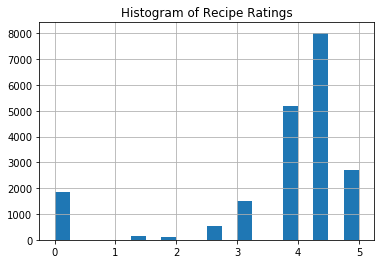

In [10]:
raw_data['rating'].hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [11]:
raw_data['rating'].value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

In [8]:
null_count = raw_data.isnull().sum()
null_count[null_count > 0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

So we've got ~20,000 records and 678 features.  Ratings are subdivided unusually, but they are not continuous.  We have missing nutritional information for ~20% of the dataset.

We'll make a quick model, naively assuming all features are useful. Nutritional information will be dropped completely for now, so we don't have to consider how to impute them.


# SVM Regression

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

X = raw_data.drop(columns=['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], axis=1)
Y = raw_data['rating']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

svr = SVR(gamma='scale')
svr.fit(X_train, Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

0.07600469416147249


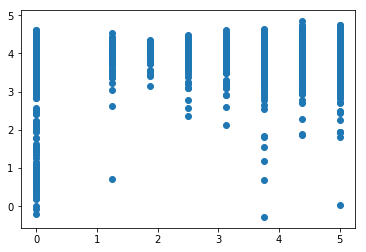

In [20]:
print(svr.score(X_test, Y_test))

plt.scatter(Y_test, svr.predict(X_test))
plt.show()

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X_train, Y_train, cv=5)

array([0.08270438, 0.07278775, 0.05131503, 0.06371029, 0.08616855])

# Poor Model

This is a drastically poor model.  Mostly because we have a discrete target variable and the model is attempting to predict using a continuous regressor.  We also seem to have an overfitting issue based on the CV scores.



# \#Challenge: Make an Improved Model

The challenge is now to turn this problem into a binary classification problem and trim the feature set down to the ~30 most valuable features.

In [30]:
print('4 stars and above: ', ((raw_data['rating'] >= 4).sum() / raw_data['rating'].count()))

4 stars and above:  0.5355076800319171


My usual rule for using an online recipe is to only look for +4 star reviews.  I will use this rule for creating the binary target variable.  It's also nice that it creates evenly balanced classes.

In [32]:
raw_data['4+rating'] = np.where(raw_data['rating'] >= 4, 1, 0)


In [34]:
raw_data[['rating', '4+rating']].sample(10)

,rating,4+rating
1849,4.375,1
4450,4.375,1
6215,3.750,0
2031,3.125,0
15390,5.000,1
9798,4.375,1
15318,4.375,1
4023,4.375,1
13072,3.750,0
9251,3.125,0


In [35]:
# Creating new train/test splits for the new target
X2 = raw_data.drop(columns=['4+rating', 
                           'rating', 
                           'title', 
                           'calories', 
                           'protein', 
                           'fat', 
                           'sodium'], axis=1)
Y2 = raw_data['4+rating'].copy()

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2)

To determine the top features, we will run a quick decision tree and save out the `feature_importances_`.

In [46]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(X2_train, Y2_train)
feat_importance = dtree.feature_importances_

In [47]:
features = pd.DataFrame({
    'feature': X2.columns,
    'importance': feat_importance,
})

features = features.sort_values('importance', ascending=False
                               ).reset_index(drop=True)[:50]

In [48]:
features

,feature,importance
0,quick & easy,0.015660
1,summer,0.013441
2,bake,0.012940
3,sauté,0.010634
4,fruit,0.009905
5,ginger,0.009834
6,gourmet,0.009470
7,fall,0.009401
8,winter,0.009041
9,spring,0.008891


In [52]:
# While the top 30 features is arbitrary, we'll just roll with it
top_30_features = list(features.iloc[:30, 0])

X3 = pd.DataFrame()
for feat in top_30_features:
    X3 = pd.concat([X3, raw_data[feat]], axis=1)
    
X3.shape

(20052, 30)

In [53]:
Y3 = Y2.copy()

In [54]:
# Creating yet another train/test split because I'm dumb...
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3)

# Support Vector Classifier

In [57]:
from sklearn.svm import SVC

svc = SVC(gamma='scale')
svc.fit(X3_train, Y3_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [59]:
svc.score(X3_train, Y3_train)

0.5921936298956048

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

Y3_ = svc.predict(X3_test)

print(confusion_matrix(Y3_test, Y3_))
print('F1 score: ', f1_score(Y3_test, Y3_))

[[ 762 1545]
 [ 530 2176]]
F1 score:  0.6771433016959703


# Model thoughts

This isn't a terrible model, but it isn't masterful either.  We definitely have a low recall issue -- predicting far too many good recipes than actually exist.  This will cause consumer confidence of your recipes to decrease significantly. 

Features would need to be engineered more thoroughly to combat this.  Specifically, we would want to try to populate the model with more 'negative' associations.  My assumption (and the distribution of ratings certainly feeds into this) is that most people only rate good recipes.  If that's the case then far fewer keywords are going to be associated with bad recipes and its going to be a difficult feature engineering problem.